# PDF Redaction Demo

## Working with the Indico API, it is possible to use model predictions to highlight, redact, and replace text in source PDF documents

In [1]:
from pprint import pprint
import pickle
from example_pipeline import get_client, ocr_pdf_document, get_predictions
from highlighter import Highlighter
from wand.image import Image as WImage

PDF_PATH = './tests/amazon_invoice.pdf'
OUTPUT_PATH = './jupyter_example_w_labels.pdf'

## In this demo, we are working with a model that has been trainined to identify key sections of invoices. The first page of the document we are going to feed to our model is below.

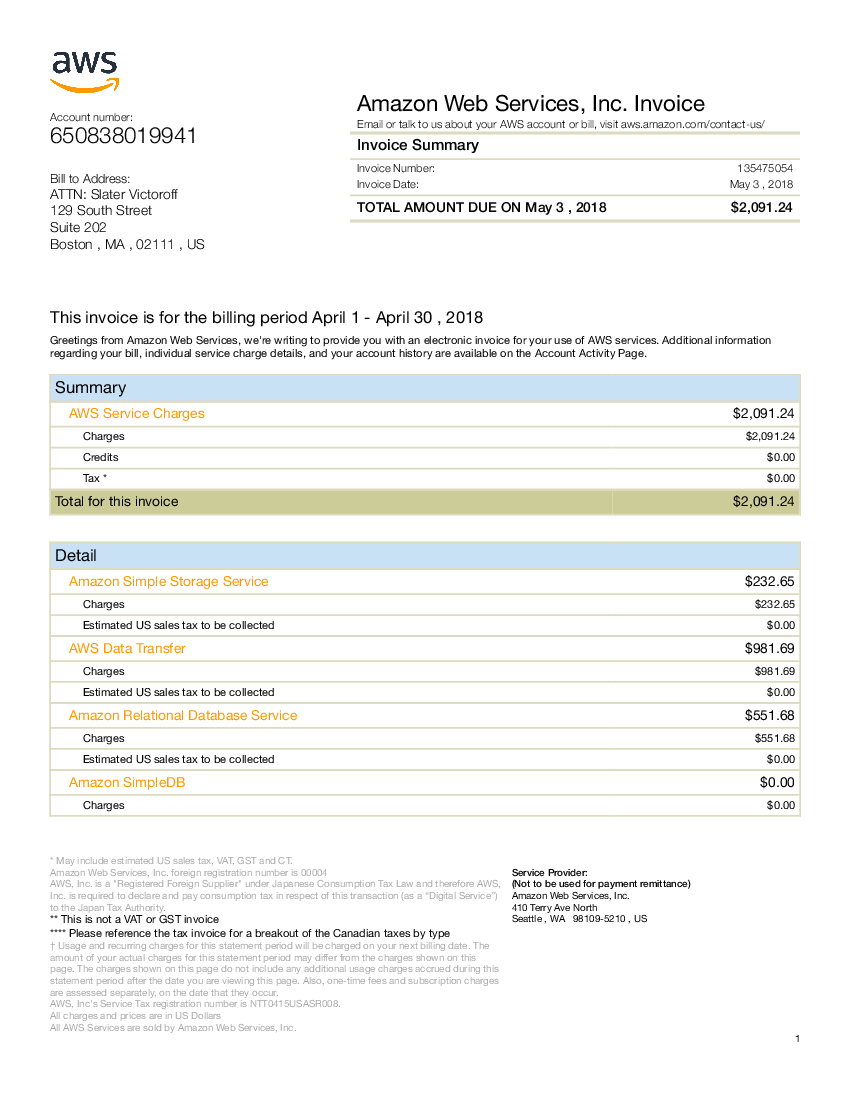

In [2]:
img = WImage(filename=PDF_PATH, resolution=100)
img

## After passing the pdf to Indico's endpoint for on-document OCR, we have the positional information for all text/objects in the PDF. 

### Below, you can see the data we've collected for the text 'Account' on the PDF's first page.

In [3]:
ocr_result = pickle.load(open( "./tests/invoice_ocr_result.p", "rb" ))
pprint(ocr_result[0]['tokens'][0])

{'block_offset': {'end': 7, 'start': 0},
 'doc_offset': {'end': 7, 'start': 0},
 'page_num': 0,
 'page_offset': {'end': 7, 'start': 0},
 'position': {'bbBot': 362,
              'bbLeft': 148,
              'bbRight': 268,
              'bbTop': 337,
              'bottom': 362,
              'left': 148,
              'right': 268,
              'top': 337},
 'style': {'background_color': '',
           'bold': 'False',
           'font_face': 'DejaVu Serif',
           'font_size': 166,
           'italic': 'False',
           'text_color': '',
           'underlined': 'False'},
 'text': 'Account'}


## After feeding the PDF's text to our trained model through the API, the values we hope to extract our returned to us as labeled predictions and associated prediction confidences 

In [4]:
predictions = pickle.load(open( "./tests/invoice_predictions.p", "rb" ))
pprint(predictions[0][1])

{'confidence': {'<PAD>': 0.0942082479596138,
                'Account Number': 0.00010658686369424686,
                'Amount': 5.55431361135561e-05,
                'Currency': 0.00047901817015372217,
                'Invoice Number': 0.00030593847623094916,
                'Line Item': 0.006157910916954279,
                'Routing Number': 0.00013710786879528314,
                'Total': 0.0005772627191618085,
                'Vendor': 0.8979724049568176},
 'end': 149,
 'label': 'Vendor',
 'start': 125,
 'text': 'Amazon Web Services, Inc'}


## Using Indico's Higlighter tool, we map our predictions to their x-y coordinates on each page of the document

In [7]:
redact = Highlighter(ocr_result)
redact.collect_positions(predictions)
redact.redact_pdf(PDF_PATH, OUTPUT_PATH, color_black=True)

## On the source document below, we can now see that our predictions have been covered

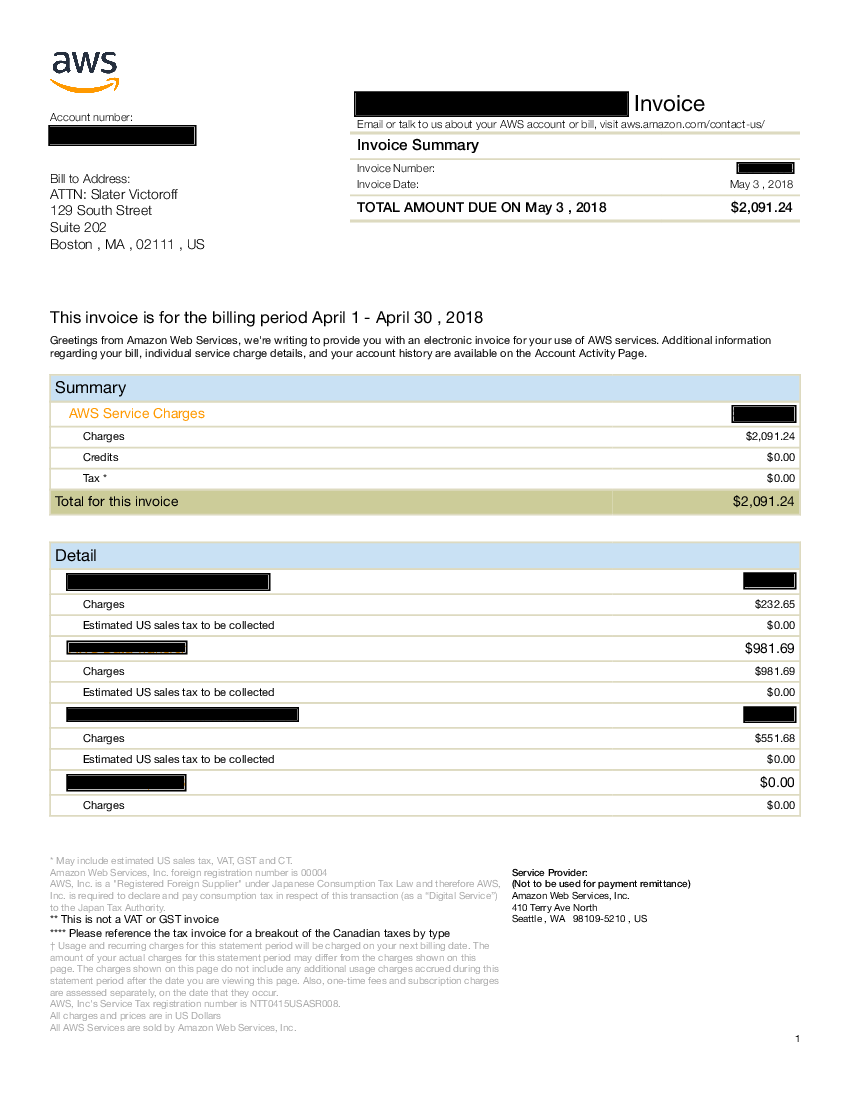

In [9]:
img = WImage(filename=OUTPUT_PATH, resolution=100)
img

## Additionally, instead of covering the predicted values in black, we can replace them on the source document with randomly generated data. 

## There are a myriad of options for the data generation, from addresses and names to numbers, currency, and more. Below, we map the labels from the extraction model to the data generation options we want. 

In [11]:
label_map = {
    'Invoice Number': 'numerify', 
    'Vendor': 'company', 
    'Total': 'numerify',  
    'Line Item': 'company',
    'Currency': 'currency', 
    'Amount': 'numerify'
}

In [14]:
redact = Highlighter(ocr_result)
redact.collect_positions(predictions)
redact.redact_and_replace(PDF_PATH, OUTPUT_PATH, fill_text=label_map)

## If you compare the newly generated document with the original above, you will see that the private data has been replaced with random numbers, names, and figures

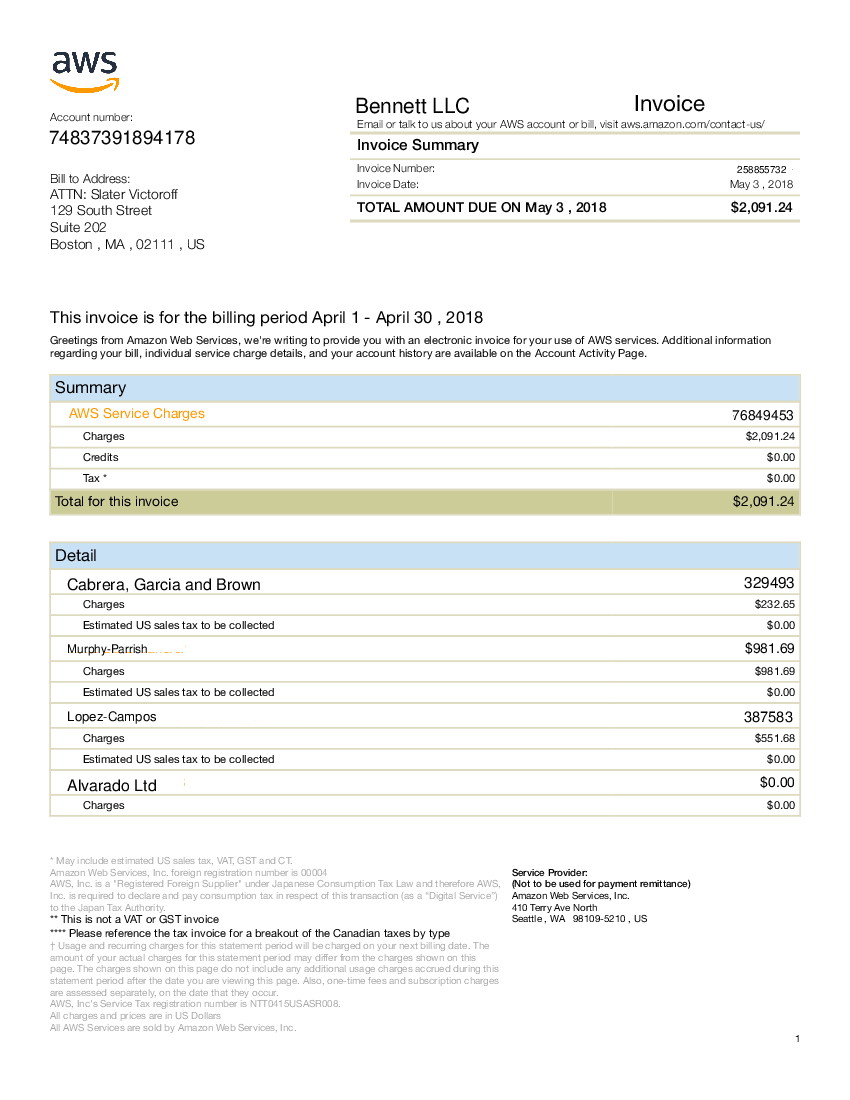

In [15]:
img = WImage(filename=OUTPUT_PATH, resolution=100)
img